## Análisis de Características de Escucha de Canciones para un Usuario en una Plataforma de Streaming de Música Mediante Métodos de Aprendizaje Automático No Supervisado

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spotipy as sp

featsDF=pd.read_csv("/app/data/data.csv")
print(featsDF.head(10))

                       id  danceability  energy  key  loudness  mode  \
0  3YCcsuRdJArE4rsAG5V3sW         0.767   0.702    4    -5.952     0   
1  0Gx4VrHzS7pZOEAGrmXXBH         0.745   0.944    0    -3.959     1   
2  05zCw24BdvZKGeC5NXowVe         0.697   0.656    9    -7.062     0   
3  1fvUFrI1xldRHB2yopccjn         0.500   0.922    9    -4.468     1   
4  5LzZBMRQ8Ui4eu5uGIO4Zh         0.612   0.536    5    -9.658     1   
5  1NXvuBAq48QrxRFQZVmORQ         0.439   0.852   11    -8.967     0   
6  3BiiSLo0wyHAY7lpCEO6ge         0.501   0.684   11    -6.706     1   
7  2Ldb2ytuC9AxhpAkVEJBI6         0.822   0.300    0    -8.034     1   
8  0rt63HYAAIzUZo5O2D0uA6         0.471   0.396    8    -6.654     1   
9  1i4F583d9v9RabcfOlKKVL         0.485   0.540    1    -5.400     1   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  
0       0.0316      0.157000          0.000091    0.0633    0.869  104.619  
1       0.1340      0.210000          0.000001    0.3

In [2]:
#Dataframe para procesar
featsDFData=featsDF.loc[ : ,featsDF.columns != 'id']

#Array para PCA y K Mean
featsArray=np.array(featsDFData)

#Feature Labels
featsLabel=["danceability","energy","key","loudness","mode", "speechiness", \
            "acousticness", "instrumentalness", "liveness", "valence", "tempo"]

### 1. PCA - Principal Components Analysis
La siguiente sección realiza un análisis de componentes principales. En primer lugar se normaliza la muestra y genera el modelo. Luego se muestra la varianza explicada al ir agregando componentes principales. Finalmente se presenta un gráfico biplot con cuales son las variables de entrada con mayor incidencia sobre las dos primeras componentes principales. Estas también se presentan con el nombre de la variable. 

[9.64573958e-01 2.28174365e-02 1.22667964e-02 1.54954643e-04
 7.93494770e-05 4.47143822e-05 3.51090090e-05 1.48713133e-05
 5.73665065e-06 5.07263170e-06 2.00122623e-06]


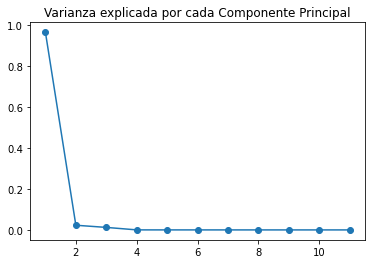

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

comp=(1,2,3,4,5,6,7,8,9,10,11)

scaler = StandardScaler()
scaler.fit(featsArray)
X=scaler.transform(featsArray)    
pca = PCA(n_components=11, random_state=1)
x_new = pca.fit_transform(featsArray)

expl_variance=(pca.explained_variance_ratio_)
print(expl_variance)

plt.scatter(x=comp, y=expl_variance )
plt.plot(comp, expl_variance )
plt.title("Varianza explicada por cada Componente Principal")
plt.show()

range(0, 11)


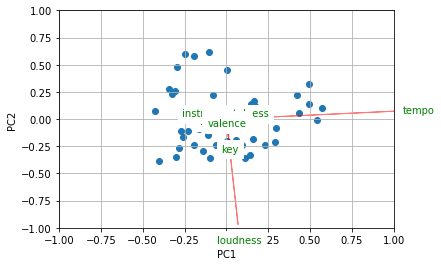

In [4]:
## Reference: https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot


def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)#, c = ys)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, featsLabel[i],\
                     color = 'g', ha = 'center', va = 'center',\
                     backgroundcolor="white")
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], \
                     color = 'g', ha = 'center', va = 'center',
                     backgroundcolor="white") 
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    print(range(n))

    
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [5]:
#PC 1
comp_PC1=list(np.absolute(pca.components_[0]))

best_comp_PC1=max(comp_PC1)
index_PC1=comp_PC1.index(best_comp_PC1)
main_comp_PC1=featsLabel[index_PC1]

print("La variable con mayor peso en la primera \
componente principal es '{}'".format(main_comp_PC1))

La variable con mayor peso en la primera componente principal es 'tempo'


In [6]:
#PC 2

comp_PC2=list(np.absolute(pca.components_[1]))

best_comp_PC2=max(comp_PC2)
index_PC2=comp_PC2.index(best_comp_PC2)
main_comp_PC2=featsLabel[index_PC2]

print("La variable con mayor peso en la segunda \
componente principal es '{}'".format(main_comp_PC2))

La variable con mayor peso en la segunda componente principal es 'loudness'


### 2. K Means Clustering

In [7]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap

## Genero una lista con lo K-num que voy a probar
num_of_cluster=[]
for x in range(11):
    num_of_cluster.append(x+2)
print(num_of_cluster)

## Itero para los distintos valores de K num
result_silhouette_kmeans=[]
 
for knum in num_of_cluster:
    kmeans=KMeans(n_clusters=knum, random_state=1)
    y=kmeans.fit_predict(featsDFData)
    
    score_kmeans = silhouette_score(featsDFData, y)
    result_silhouette_kmeans.append(score_kmeans)


## Buscamos el mejor valor de número de clusters
result_silhouette_kmeans 
best_silhouette_kmeans=max(result_silhouette_kmeans)
index_kmeans=result_silhouette_kmeans.index(best_silhouette_kmeans)
 
best_knum=num_of_cluster[index_kmeans]
 
print("El mejor número de clusters es = {}, \
siendo el valor de silhouette {})".format(best_knum, best_silhouette_kmeans))

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
El mejor número de clusters es = 3, siendo el valor de silhouette 0.5812236273769709)


In [17]:
kmeans=KMeans(n_clusters=best_knum)
model=kmeans.fit(featsDFData)

featsDF["clusterLabel"] = model.labels_

kmeans_centroid=model.cluster_centers_

print("Centroides de los clusters")
print(kmeans_centroid)
pd.DataFrame(kmeans_centroid)

Centroides de los clusters
[[ 6.12842105e-01  5.82894737e-01  5.94736842e+00 -8.03005263e+00
   7.36842105e-01  4.61473684e-02  2.95437000e-01  8.15898958e-02
   1.26078947e-01  5.29789474e-01  1.29362684e+02]
 [ 4.81500000e-01  6.61333333e-01  4.83333333e+00 -8.55783333e+00
   6.66666667e-01  7.90333333e-02  1.47086667e-01  1.80983575e-01
   1.75683333e-01  4.66833333e-01  1.74031500e+02]
 [ 4.92688000e-01  4.07718800e-01  3.88000000e+00 -1.24931200e+01
   8.00000000e-01  6.10920000e-02  4.85456000e-01  2.38731796e-01
   1.62268000e-01  4.29636000e-01  8.53042800e+01]]


,0,1,2,3,4,5,6,7,8,9,10
0,0.612842,0.582895,5.947368,-8.030053,0.736842,0.046147,0.295437,0.081590,0.126079,0.529789,129.362684
1,0.481500,0.661333,4.833333,-8.557833,0.666667,0.079033,0.147087,0.180984,0.175683,0.466833,174.031500
2,0.492688,0.407719,3.880000,-12.493120,0.800000,0.061092,0.485456,0.238732,0.162268,0.429636,85.304280


**Se presentan los agrupamientos utilizando como dimensiones las dos variables con mayor injerencia en las primeras dos componentes principales. Se observa como las observaciones están en dos zonas bien distintas**

Text(0, 0.5, 'loudness')

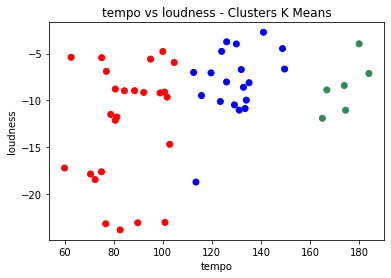

In [18]:
colors=['blue', 'yellow', 'cyan', 'seagreen','peru', 'magenta', 'red']

plt.scatter(featsDFData[main_comp_PC1], featsDFData[main_comp_PC2], \
            c=featsDF["clusterLabel"],  cmap=ListedColormap(colors))
plt.title("{} vs {} - Clusters K Means".format(main_comp_PC1, main_comp_PC2))
plt.xlabel(main_comp_PC1)
plt.ylabel(main_comp_PC2)

**El usuario puede también analizar los agrupamientos con otras variables. Se observa como las observaciones están más mezcladas que en el caso anterior**

Text(0, 0.5, 'instrumentalness')

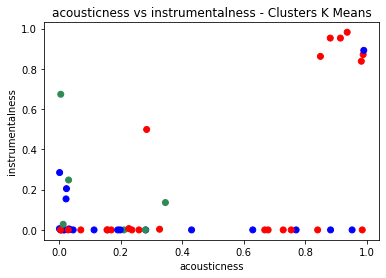

In [19]:
#Modificar "var1" y "var2" para comparar los resultados con distintos audio features
var1="acousticness"
var2="instrumentalness"

plt.scatter(featsDFData[var1], featsDFData[var2], \
            c=featsDF["clusterLabel"],  cmap=ListedColormap(colors))
plt.title("{} vs {} - Clusters K Means".format(var1, var2))
plt.xlabel(var1)
plt.ylabel(var2)

### 3. Self Organizing Maps

In [11]:
from sklearn_som.som import SOM
from matplotlib.colors import ListedColormap

## Genero una lista con lo matrix_dim que voy a probar
matrix_dim=[]
for x in range(11):
    matrix_dim.append(x+2)
print(matrix_dim)

## Itero para los distintos valores de matrix_dim
result_silhouette_som=[]

for mtx in matrix_dim:

    spotify_som = SOM(m=mtx, n=1, dim=11, random_state=1)
    SOMClassification=spotify_som.fit(featsArray)

    y=spotify_som.predict(featsArray)
    
    score_som = silhouette_score(featsArray, y)
    result_silhouette_som.append(score_som)

## Buscamos el mejor valor
result_silhouette_som
best_silhouette_som=max(result_silhouette_som)

index_som=result_silhouette_som.index(best_silhouette_som)
best_som=num_of_cluster[index_som]

print("El mejor matrix dim es = {}, siendo el \
valor de silhouette {})".format(best_som, best_silhouette_som))

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
El mejor matrix dim es = 2, siendo el valor de silhouette 0.5687090095607065)


In [12]:
print(best_som)
spotify_som = SOM(m=best_som, n=1, dim=11, random_state=1)
SOMClassification=spotify_som.fit(featsArray)
SOMClass=spotify_som.predict(featsArray)

2


In [33]:
som_centroid=spotify_som.cluster_centers_

print("Centorides")
print(som_centroid)

type(som_centroid)


Centorides
[[[ 5.77862747e-01  5.50478067e-01  6.28762979e+00 -8.76949678e+00
    6.60427541e-01  5.16802861e-02  3.63290050e-01  1.12261980e-01
    1.47745125e-01  4.91040411e-01  1.22636046e+02]]

 [[ 5.15159066e-01  5.30868030e-01  5.41322538e+00 -1.05108393e+01
    6.40580209e-01  6.70985229e-02  4.23887513e-01  2.39273321e-01
    1.90910196e-01  4.88778140e-01  9.92479968e+01]]]


numpy.ndarray

**Se presentan los agrupamientos utilizando como dimensiones las dos variables con mayor injerencia en las primeras dos componentes principales. Se observa como las observaciones están en dos zonas bien distintas. El resultado con SOM es similar al de K-Means**

Text(0, 0.5, 'loudness')

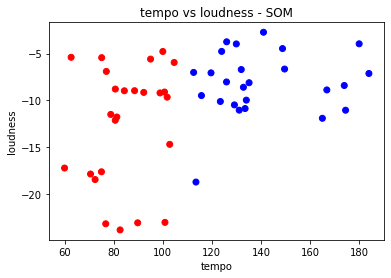

In [22]:
plt.scatter(featsArray[0:,index_PC1], featsArray[0:,index_PC2],\
            c=SOMClass, cmap=ListedColormap(colors))
plt.title("{} vs {} - SOM".format(main_comp_PC1, main_comp_PC2))
plt.xlabel(main_comp_PC1)
plt.ylabel(main_comp_PC2)

**El usuario puede también analizar los agrupamientos con otras variables. Se observa como las observaciones están más mezcladas que en el caso anterior. El resultado con SOM es similar al de K-Means**

Text(0, 0.5, 'instrumentalness')

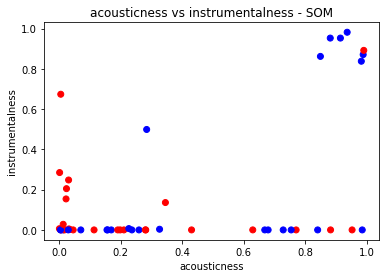

In [23]:
#Modificar "var1" y "var2" para comparar los resultados con distintos audio features
var1="acousticness"
var2="instrumentalness"

plt.scatter(featsArray[0:,featsLabel.index(var1)], \
            featsArray[0:,featsLabel.index(var2)], \
            c=-SOMClass, cmap=ListedColormap(colors))
plt.title("{} vs {} - SOM".format(var1, var2))
plt.xlabel(var1)
plt.ylabel(var2)

### 4. Comparación K-Means vs SOM

In [16]:
if (best_silhouette_kmeans > best_silhouette_som):
    print("El mejor algoritmo es K-Means, con un número de cluster = {}, \
    y un valor de silhouette {}".format(best_knum, best_silhouette_kmeans))

elif (best_silhouette_kmeans < best_silhouette_som):
    print("El mejor algoritmo es SOM, con un matrix dim = {}, \
    y un valor de silhouette {}".format(best_som, best_silhouette_som))

else:
    print("K-Means y SOM generan agrupamientos con igual coeficiente \
    silhouette de {}. El número de clusters en K-Means es {}, \
    y el matrix dim en SOM es {}".format(best_silhouette_kmeans, best_knum, best_som))

El mejor algoritmo es K-Means, con un número de cluster = 3,     y un valor de silhouette 0.5812236273769709
